To compare different training methods (here, one with SAM and one without) we take the results, store them, and plot them in the same function.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle


def plot_individual_traces(minima_results, minima_trained_on_additional_data_level, base_shift, color, alpha, sort_x):
    """
    Plot volumes for minima trained with a given amount of additional data.

    Args:
        minima_results (list[dict]): Each entry represents one minima and contains:
            {
                "data_levels": list[int|float],  # Data levels used when probing the minima
                "log_exp": list[float],          # Corresponding log(volume) values
            }

        minima_trained_on_additional_data_level (int|float):
            The amount of *additional data* used when this minima was originally trained.
            (Used for highlighting its "own" training point in the plot.)

        base_shift (int):
            Constant shift applied to x-values, used when converting relative data levels
            to absolute dataset sizes (e.g., when base_train_size is nonzero).
        color (tuple):
        alpha (float):
        sort_x (bool):
    Returns:
        tuple[list[np.ndarray], list[np.ndarray]]:
            all_x, all_y — Lists containing x and y arrays for every minima trace.
    """
    all_x, all_y = [], []

    # Ensure all traces have consistent length (shortest minima determines)
    min_len = min(len(m["log_exp"]) for m in minima_results)
    print(f"Plotting minima trained with {minima_trained_on_additional_data_level} additional data points")

    for minima in minima_results:
        x_vals = [x + base_shift for x in minima["data_levels"][:min_len]]
        y_vals = minima["log_exp"][:min_len]

        # Sort by x for consistent plotting
        if sort_x:
            x_vals, y_vals = zip(*sorted(zip(x_vals, y_vals), key=lambda p: p[0]))

        # Plot the trace
        plt.plot(x_vals, y_vals, marker="o", color=color, alpha=alpha)
        all_x.append(x_vals)
        all_y.append(y_vals)

        # Highlight the point corresponding to the minima’s own training data level
        training_point = minima_trained_on_additional_data_level + base_shift
        if training_point in x_vals:
            idx = x_vals.index(training_point)
            plt.scatter(
                training_point, y_vals[idx],
                color=color,
                s=50,
                alpha=alpha,
                zorder=3
            )

    return all_x, all_y


def plot_average_curve(minima_results, minima_trained_on_additional_data_level, base_shift, color, sort_x, central_tendency):
    """
    Plot the average (mean or median) curve across all minima trained with a certain data level.

    Args:
        minima_results (list[dict]):
            List of minima result dictionaries, each containing:
                {
                    "data_levels": list[int|float],
                    "log_exp": list[float],
                }

        minima_trained_on_additional_data_level (int|float):
            Amount of additional data used to train this group of minima.
            (Used for highlighting the training-level point.)

        base_shift (int):
        color (tuple):
        sort_x (bool):
        central_tendency (str): Either "mean" or "median" — determines which statistic to plot as the central line.

    Returns:
        tuple[np.ndarray, np.ndarray]:
            data_levels, center_y — the x and y coordinates of the averaged curve.
    """
    # Truncate all traces to match the shortest one
    min_len = min(len(m["log_exp"]) for m in minima_results)
    log_exp_matrix = np.array([m["log_exp"][:min_len] for m in minima_results])
    data_levels = np.array([x + base_shift for x in minima_results[0]["data_levels"][:min_len]])

    # Compute central tendency and spread
    if central_tendency == "median":
        center_y = np.median(log_exp_matrix, axis=0)
        y_low = np.percentile(log_exp_matrix, 25, axis=0)
        y_high = np.percentile(log_exp_matrix, 75, axis=0)
    else:
        center_y = np.mean(log_exp_matrix, axis=0)
        y_std = np.std(log_exp_matrix, axis=0)
        y_low = center_y - y_std
        y_high = center_y + y_std

    # Optional sorting
    if sort_x:
        data_levels, center_y, y_low, y_high = map(np.array, zip(*sorted(
            zip(data_levels, center_y, y_low, y_high),
            key=lambda p: p[0]
        )))

    # Plot mean/median line and shaded area
    plt.plot(data_levels, center_y, color=color, linewidth=2.5)
    plt.fill_between(data_levels, y_low, y_high, color=color, alpha=0.2)

    return data_levels, center_y

def plot_minima_volume_vs_data_level(
    results_dict,
    xlabel="Loss Landscape Data Level",
    ylabel="Log Volume",
    title=None,
    suptitle=None,
    alpha=0.7,
    log_scale=False,
    output_dir="imgs/volume_plots",
    filename="minima_volume",
    sort_x=False,
    plot_average=False,
    plot_only_average=False,
    show_plot=True,
    central_tendency="mean",
    xlabel_size=12, ylabel_size=12, title_size=14, suptitle_size=18,
    legend_size=12, legend_title_fontsize=12, legend_loc="best",
    show_legend=True,
    data_type=None,
    base_train_size=None,
    xlim=None,
    ylim=None,
    yticks=None,
):
    """
    Plot the minima volumes (log volume) versus the data level they were evaluated on.

    -------------------------------------------------------------------------------
    Expected Format of `results_dict`:
    -------------------------------------------------------------------------------
    `results_dict` is a dictionary where:
        - **Keys** are the additional data levels used to train each minima.
          Example: 0, 50, 100, ... (number of extra training examples used for minima).

        - **Values** are lists of experiment results, where each experiment result
          is itself a dictionary representing one minima. Each minima dictionary has:
              {
                  "experiment": "model_0_data_10",       # Name or identifier of the minima
                  "log_exp": [923312.2196997597, 0],     # List of log(exp(r/n)) values for each data level, last is usually 0
                  "test_loss": [2.2788678636550905],     # List of test loss values (not always used here)
                  "data_levels": [0, 62]                 # Data levels where this minima was evaluated, last is where it exceeds threshold
              }

    For example:
        results_dict[0] → list of 10 minima trained on *0 additional data*.
        Each minima entry shows how its volume/log_exp changes across data_levels.

    -------------------------------------------------------------------------------
    How the function works:
    -------------------------------------------------------------------------------
    1. For each `minima_trained_on_additional_data_level` (the dict key),
       it gathers all corresponding minima results.
    2. Each minima trace (`log_exp` vs `data_levels`) is plotted individually.
    3. Optionally, a mean or median curve across all minima is plotted with shading.
    4. The point corresponding to the minima’s own training level is highlighted.
    5. The figure is optionally saved and/or displayed.
    -------------------------------------------------------------------------------
    """

    # --- Figure setup ---
    if title is None:
        title = f"{ylabel} vs {xlabel}"

    plt.figure(figsize=(6, 5), constrained_layout=True)
    color_cycle = cycle(plt.cm.tab10.colors)
    level_to_color = {level: next(color_cycle) for level in results_dict.keys()}

    found_minima_vol, found_minima_dataset = [], []

    # Legend title depends on whether we're plotting data experiments
    legend_title = "Trained on:" if data_type else "Minima Trained on Data Level"
    base_shift = base_train_size if data_type == "data" else 0

    # --- Iterate over all minima training levels ---
    for minima_trained_on_additional_data_level, exp_results in results_dict.items():
        color = level_to_color[minima_trained_on_additional_data_level]

        # Label for legend
        if data_type is None:
            label_str = f"Level {minima_trained_on_additional_data_level}"
        elif data_type == "data":
            if base_train_size is None:
                raise ValueError("base_train_size must be provided when data_type='data'")
            label_str = f"{minima_trained_on_additional_data_level + base_train_size:,} Examples"
        elif data_type in {"poison", "noise"}:
            label_str = f"Incorrect Points: {minima_trained_on_additional_data_level}"
        else:
            raise ValueError(f"Unknown data_type: {data_type}")

        # --- Plot the minima found with this data level. ---
        if not plot_only_average:
            plot_individual_traces(
                exp_results,
                minima_trained_on_additional_data_level,
                base_shift,
                color,
                alpha,
                sort_x
            )

        # --- Plot average ± spread for minima trained on a certain amount of data ---
        if plot_average:
            data_levels, center_y = plot_average_curve(
                exp_results,
                minima_trained_on_additional_data_level,
                base_shift,
                color,
                sort_x,
                central_tendency
            )

            plt.plot([], [], color=color, linewidth=2.5, label=label_str)

            # Highlight point corresponding to where minima was trained
            training_point = minima_trained_on_additional_data_level + base_shift
            if training_point in data_levels:
                idx = np.where(data_levels == training_point)[0]
                if len(idx):
                    idx = idx[0]
                    plt.scatter(
                        training_point,
                        center_y[idx],
                        color=color,
                        s=140,
                        edgecolors="black",
                        linewidths=1.0,
                        zorder=4
                    )
                    found_minima_vol.append(training_point)
                    found_minima_dataset.append(center_y[idx])
        elif plot_only_average:
            plt.plot([], [], color=color, marker="o", linestyle="", label=label_str)

    # --- Axis and title formatting ---
    plt.xlabel(xlabel, fontsize=xlabel_size)
    plt.ylabel(ylabel, fontsize=ylabel_size)
    if log_scale:
        plt.xscale("log")

    if suptitle:
        plt.suptitle(suptitle, fontsize=suptitle_size, y=1.01)
    plt.title(title, fontsize=title_size)
    plt.grid(True)

    # --- Legend and bounds ---
    if show_legend:
        plt.legend(
            title=legend_title,
            fontsize=legend_size,
            title_fontsize=legend_title_fontsize,
            loc=legend_loc
        )

    if yticks is not None:
        plt.yticks(yticks)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    # --- Save and show ---
    if output_dir and filename:
        os.makedirs(output_dir, exist_ok=True)
        save_name = filename
        if plot_average:
            save_name += "_avg"
        if plot_only_average:
            save_name += "_onlyavg"
        save_path = os.path.join(output_dir, f"{save_name}.png")
        plt.savefig(save_path)

    if show_plot:
        plt.show()
    plt.close()

    return found_minima_vol, found_minima_dataset

In [2]:
import pprint

data_base = np.load("volumes_across_datasets_base.npz", allow_pickle=True)
results_dict_base = data_base["results_dict"].item() 

data_sam = np.load("volumes_across_datasets_SAM.npz", allow_pickle=True)
results_dict_sam = data_sam["results_dict"].item() 

Plotting minima trained with 0 additional data points
Plotting minima trained with 540 additional data points
Plotting minima trained with 1940 additional data points
Plotting minima trained with 5940 additional data points
Plotting minima trained with 19940 additional data points
Plotting minima trained with 59940 additional data points


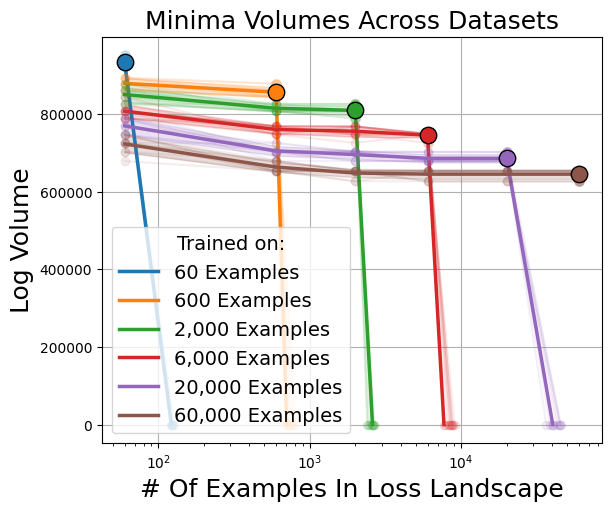

In [3]:
found_minima_vol, found_minima_dataset = plot_minima_volume_vs_data_level(
    results_dict = results_dict_base,
    data_type="data",        
    base_train_size=60, 
    xlabel="# Of Examples In Loss Landscape",
    ylabel="Log Volume",
    suptitle=None,
    title=f"Minima Volumes Across Datasets",
    log_scale = True,
    alpha=0.1,
    plot_average=True,
    output_dir="", filename="log_volumes_vs_data_levels_base",
    xlabel_size=18, ylabel_size=18, title_size=18, suptitle_size=18, legend_size=14, legend_title_fontsize=14,
)

Plotting minima trained with 0 additional data points
Plotting minima trained with 540 additional data points
Plotting minima trained with 1940 additional data points
Plotting minima trained with 5940 additional data points
Plotting minima trained with 19940 additional data points
Plotting minima trained with 59940 additional data points


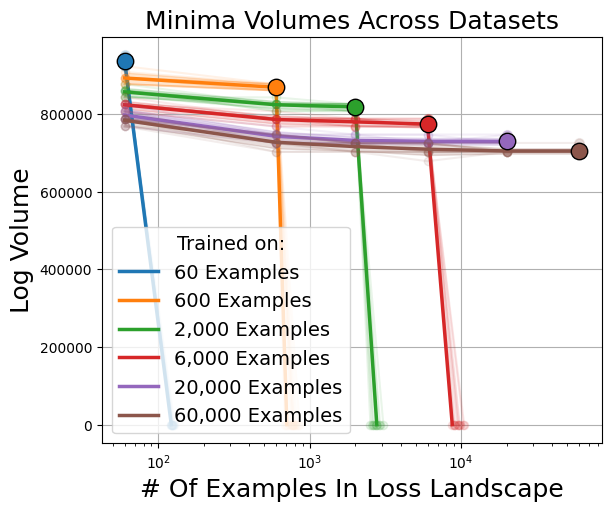

In [4]:
found_minima_vol, found_minima_dataset = plot_minima_volume_vs_data_level(
    results_dict = results_dict_sam,
    data_type="data",        
    base_train_size=60, 
    xlabel="# Of Examples In Loss Landscape",
    ylabel="Log Volume",
    suptitle=None,
    title=f"Minima Volumes Across Datasets",
    log_scale = True,
    alpha=0.1,
    plot_average=True,
    output_dir="", filename="log_volumes_vs_data_levels_sam",
    xlabel_size=18, ylabel_size=18, title_size=18, suptitle_size=18, legend_size=14, legend_title_fontsize=14,
)

# Comparison

Having simplified our plotting, we perform a comparison.

In [5]:
def compare_minima_volume_vs_data_level(
    results_dict_A,
    results_dict_B,
    label_A="Dataset A",
    label_B="Dataset B",
    colors_A=None,    # List of colors for dataset A (hex or RGB)
    colors_B=None,    # List of colors for dataset B (hex or RGB)
    n_colors=6,       # Fallback number of colors if color lists not provided
    xlabel="Data Level",
    ylabel="Log Volume",
    title=None,
    suptitle=None,
    alpha=0.5,
    log_scale=False,
    output_dir="",
    filename="compare_minima_volume",
    sort_x=False,
    plot_average=True,
    plot_only_average=False,
    show_plot=True,
    central_tendency="mean",
    xlabel_size=12,
    ylabel_size=12,
    title_size=14,
    suptitle_size=18,
    legend_size=12,
    legend_title_fontsize=12,
    legend_loc="best",
    show_legend=True,
    data_type=None,
    base_train_size=None,
    xlim=None,
    ylim=None,
    yticks=None,
    tick_size = 12,
):
    """
    Compare minima volumes across two different experiment conditions.

    -------------------------------------------------------------------------------
    Expected Format of Each `results_dict`:
    -------------------------------------------------------------------------------
    Each results_dict maps:
        minima_trained_on_additional_data_level (int|float) → list of minima dictionaries
    Each minima dictionary contains:
        {
            "experiment": str,
            "log_exp": list[float],
            "test_loss": list[float],
            "data_levels": list[int|float]
        }

    -------------------------------------------------------------------------------
    How it works:
    -------------------------------------------------------------------------------
    - Plots each `results_dict` using its own color set.
    - Each group of minima shares a single legend label (label_A or label_B).
    - Useful for visually comparing two training strategies.
    """

    if title is None:
        title = f"{ylabel} vs {xlabel} — Comparison"

    fig = plt.figure(figsize=(6, 5), constrained_layout=True)
    ax = plt.gca()
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,2)) 
    ax.yaxis.get_offset_text().set_fontsize(12)  # Change 20 to your desired size
    
    keys_A = list(results_dict_A.keys())
    keys_B = list(results_dict_B.keys())

    # --- Determine colors ---
    if colors_A is None:
        # fallback to blue-green cycle
        color_cycle_A = cycle(plt.cm.Blues(np.linspace(0.3, 1, n_colors)))
        colors_A = [next(color_cycle_A) for _ in range(min(n_colors, len(keys_A)))]
    if colors_B is None:
        # fallback to red-yellow cycle
        color_cycle_B = cycle(plt.cm.Reds(np.linspace(0.3, 1, n_colors)))
        colors_B = [next(color_cycle_B) for _ in range(min(n_colors, len(keys_B)))]

    base_shift = base_train_size if data_type == "data" else 0

        # --- Plot dataset A ---
    for minima_trained_on_additional_data_level, exp_results in results_dict_A.items():
        color = colors_A[keys_A.index(minima_trained_on_additional_data_level) % len(colors_A)]
        if not plot_only_average:
            plot_individual_traces(
                exp_results,
                minima_trained_on_additional_data_level,
                base_shift,
                color,
                alpha,
                sort_x,
            )
        if plot_average:
            data_levels, center_y = plot_average_curve(
                exp_results,
                minima_trained_on_additional_data_level,
                base_shift,
                color,
                sort_x,
                central_tendency,
            )
    
            # Highlight the point corresponding to the minima’s own training level
            training_point = minima_trained_on_additional_data_level + base_shift
            idx_matches = np.where(np.isclose(data_levels, training_point))[0]
            if len(idx_matches):
                idx = idx_matches[0]
                plt.scatter(
                    training_point,
                    center_y[idx],
                    color=color,
                    s=140,
                    edgecolors="black",
                    linewidths=1.0,
                    zorder=4
                )

    # --- Plot dataset B ---
    for i, (minima_trained_on_additional_data_level, exp_results) in enumerate(results_dict_B.items()):
        color = colors_B[i % len(colors_B)]
        if not plot_only_average:
            plot_individual_traces(
                exp_results,
                minima_trained_on_additional_data_level,
                base_shift,
                color,
                alpha,
                sort_x,
            )
        if plot_average:
            data_levels, center_y = plot_average_curve(
                exp_results,
                minima_trained_on_additional_data_level,
                base_shift,
                color,
                sort_x,
                central_tendency,
            )
    
            # Highlight the point corresponding to the minima’s own training level
            training_point = minima_trained_on_additional_data_level + base_shift
            idx_matches = np.where(np.isclose(data_levels, training_point))[0]
            if len(idx_matches):
                idx = idx_matches[0]
                plt.scatter(
                    training_point,
                    center_y[idx],
                    color=color,
                    s=140,
                    edgecolors="black",
                    linewidths=1.0,
                    zorder=4
                    
                )
    # --- Add one legend entry per dataset ---
    plt.plot([], [], color=colors_A[-1], linewidth=3, label=label_A)
    plt.plot([], [], color=colors_B[-1], linewidth=3, label=label_B)

    # --- Axis and title formatting ---
    plt.xlabel(xlabel, fontsize=xlabel_size)
    plt.ylabel(ylabel, fontsize=ylabel_size)

    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    
    if log_scale:
        plt.xscale("log")
    plt.grid(True)

    if suptitle:
        plt.suptitle(suptitle, fontsize=suptitle_size, y=1.01)
    plt.title(title, fontsize=title_size)

    # --- Legend ---
    if show_legend:
        plt.legend(
            fontsize=legend_size,
            title_fontsize=legend_title_fontsize,
            loc=legend_loc,
        )

    # --- Axis limits and ticks ---
    if yticks is not None:
        plt.yticks(yticks)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    # --- Save and show ---
    if output_dir and filename:
        os.makedirs(output_dir, exist_ok=True)
        save_path = os.path.join(output_dir, f"{filename}.png")
        plt.savefig(save_path)

    if show_plot:
        plt.show()
    plt.close()


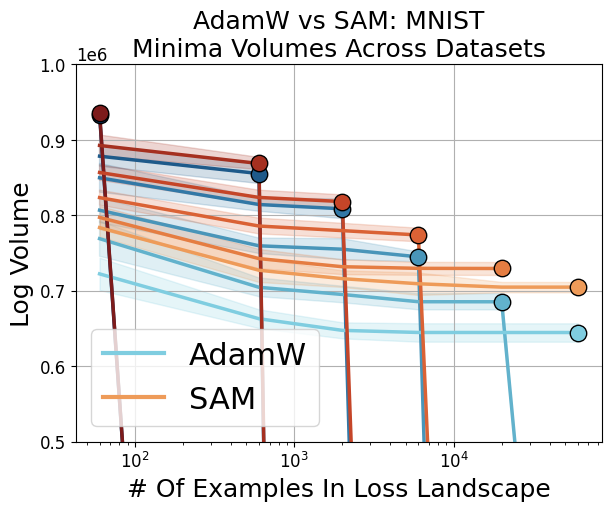

In [6]:
compare_minima_volume_vs_data_level(
    results_dict_A=results_dict_base,
    results_dict_B=results_dict_sam,
    label_A="AdamW",
    label_B="SAM",
    
    # Color lists for each dataset
    colors_A = [
        "#0a3c6e",  # deep navy
        "#1e5a8a",  # medium navy-blue
        "#3278a6",  # slate blue
        "#4995b9",  # lighter blue
        "#62b2cc",  # sky blue
        "#7fcde0"   # pale blue
    ],

    colors_B = [
        "#7d1b1b",  # deep red
        "#a53020",  # red
        "#c54528",  # reddish-orange
        "#da6235",  # orange
        "#e57d42",  # light orange
        "#ee9b59"   # soft amber
    ],
    
    # Plotting options
    data_type="data",
    base_train_size=60,
    xlabel="# Of Examples In Loss Landscape",
    ylabel="Log Volume",
    title="AdamW vs SAM: MNIST\nMinima Volumes Across Datasets",
    log_scale=True,
    alpha=0.15,
    plot_average=True,
    plot_only_average=True,
    
    # Figure output
    output_dir="imgs",
    filename="log_volumes_vs_data_levels_adamw_vs_sam",
    
    # Font sizes and legend
    xlabel_size=18,
    ylabel_size=18,
    title_size=18,
    suptitle_size=18,
    legend_size=22,                # Legend labels font size
    legend_title_fontsize=22,      # Legend title font size
    legend_loc="lower left",       # Legend position
    tick_size = 12,
    
    # Axes limits
    ylim=(500_000, 1_000_000)
)
